In [150]:
import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc
import decoupler as dc
import os
import re
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
#import pyreadr

In [ ]:
def validate_input_arguments (arguments_list):
    if arguments_list["out_path"] is None:
        print("Please provide an output path")
    elif arguments_list["out_path"][-1] != "/":
        arguments_list["out_path"] = arguments_list["out_path"] + "/"

    if arguments_list["celltype"] is None:
        print("Please provide the name of the metadata field containing cell type annotations")

    if arguments_list["condition"] is None:
        print("Please provide the name of the metadata field containing condition annotations")

    if arguments_list["organism"] is None:
        arguments_list["organism"] = "human"

    if arguments_list["comparison_list"] is None:
        arguments_list["comparison_list"] = np.nan

    if arguments_list["logfc"] is None:
        arguments_list["logfc"] = 0.0

    if arguments_list ["pval"] is None:
        arguments_list["pval"] = 0.05

    if arguments_list["reg"] is None:
        arguments_list["reg"] = load_dorothea_regulon(arguments_list["organism"])

    elif isinstance(arguments_list["reg"], str):
        arguments_list["reg"] = pd.read_csv(arguments_list["reg"], index_col=0)
        arguments_list["reg"] = pd.DataFrame.rename(arguments_list["reg"], columns={"source" : "tf"})

    if not "tf" in arguments_list["reg"] and "target" in arguments_list["reg"] and "weight"in arguments_list["reg"]:
        raise Exception("Not all necessary columns found in regulon table! Please make sure that the regulon has the columns source, target and weight!")
    
 
   
    return(arguments_list)



In [ ]:
def AverageExpression(sub_object, celltype = None, name_iterable = None, outpath = None):
    gene_ids = sub_object.var.index.values
    #cluster line even necessary if not returned?
    #clusters = anndataobject.obs[celltype].cat.categories
    obs = sub_object[:,gene_ids].X.toarray()
    obs = np.expm1(obs)
    avg_df = pd.DataFrame(obs,columns=gene_ids,index= sub_object.obs[celltype])
    avg_df = avg_df.groupby(level=0, observed=False).mean()
    avg_df.T.to_csv(outpath + name_iterable + "_average_gene_expression_by_cluster_exp.csv")

    return avg_df.T


In [ ]:
def eval_pval(p_val):
    p_val = float(p_val)
    if p_val < 0.001: 
      txt = "***"
    elif p_val < 0.01: 
      txt = "**"
    elif p_val < 0.05: 
      txt = "*"
    else:
      txt = "ns"
    return(txt)


def eval_log_fc_tag(log_fc):
    if log_fc >= 1.0: 
      txt = "***"
    elif log_fc > 0.5: 
      txt = "**"
    elif log_fc > 0.0: 
      txt = "*"
    else:
      txt = "ns"
    return(txt)

In [190]:
def create_unfiltered_tf_scores(tf_scores_df, condition, celltype, out_path):   
    summarized_tf_scores_df = tf_scores_df.groupby(celltype, observed = False).mean().T
    #agg(["mean", "var"])
    summarized_tf_scores_df.to_csv(out_path + "/unfiltered_tf_scores_" + condition + ".csv")
    return summarized_tf_scores_df

#np.var() returns a value that is different from R's var(), whereas statistics.variance() is the same as R's var()
def save_variable_tf_score(filtered_summarized_tf_scores_df, condition, out_path, plot):
    filtered_summarized_tf_scores_df["var"] = filtered_summarized_tf_scores_df.apply(statistics.variance, axis=1).unique()
    filtered_summarized_tf_scores_df.to_csv(out_path + "/variable_tf_scores_" + condition + ".csv")

    if plot:
        top_variable_tfs = filtered_summarized_tf_scores_df.sort_values("var", ascending=False).head(n=20).drop(columns="var")
        fig, ax = plt.subplots(figsize=(8,7))   
        ax = sns.heatmap(top_variable_tfs, cmap="coolwarm", center=0, vmin=top_variable_tfs.min(axis=None), cbar_kws={"label": "z-score"})
        ax.set(xlabel="Cell Type", ylabel="Transcription Factor")
        ax.get_figure()
        plt.savefig(out_path + "/tf_activity_top20_variable_" + condition + ".pdf")
        plt.close()

    filtered_summarized_tf_scores_df_var = filtered_summarized_tf_scores_df
    return filtered_summarized_tf_scores_df_var
    

In [201]:
def plot_tf_activity(filtered_summarized_tf_scores_df, tag_mapping, condition, out_path):
    filtered_summarized_tf_scores_df = filtered_summarized_tf_scores_df.drop(columns="var")
    sns.clustermap(filtered_summarized_tf_scores_df, cbar_kws={"label": "z-score"}, figsize=(8,7))
    plt.savefig(out_path + "/tf_activity_compressed_" + condition + ".pdf")
    plt.close()

    sns.clustermap(filtered_summarized_tf_scores_df, cbar_kws={"label": "z-score"}, figsize=(8,50), annot= tag_mapping)
    plt.savefig(out_path + "/tf_activity_" + condition + ".pdf")
    plt.close()


    

In [ ]:
def map_z_value_filtered(filtered_summarized_tf_scores_df, anndataobject_markers):
    z_score = []
    for gene in anndataobject_markers["gene"]:
        if gene in filtered_summarized_tf_scores_df.index:
            z_score.append(filtered_summarized_tf_scores_df.loc[gene, anndataobject_markers["cluster"]])
    return z_score


In [208]:
#not per cluster but cluster and pval etc need to be added to csv (check against specific marker csv from lr2tf test run in R)

def get_significant_tfs_single(tf_activities_sub, celltype, condition, out_path, pval, logfc, name, plot):
    
    #does not work if condition is None
    renamed_condition = condition.replace(",", "_")
    name = name.replace(",", "_")

    single_result_path = out_path + renamed_condition 
    if not os.path.isdir(single_result_path):
        os.mkdir(single_result_path)
    
    
    #tf_activities_scaled = sc.pp.scale(tf_activities_sub, copy=True, max_value=10)
    #or sc.pp.normalize_total(anndataobject)
    #sc.pp.log1p(tf_activities) 
    # "warning: seems to be already log transformed"

    number_of_clusters = len(tf_activities_sub.obs["new_annotation"].cat.categories) 


    sc.tl.rank_genes_groups(tf_activities_sub, groupby= "new_annotation", reference="rest", method="wilcoxon", key_added="wilcoxon_markers", corr_method= "bonferroni")
    #sc.tl.filter_rank_genes_groups(anndataobject, min_in_group_fraction=0, key="wilcoxon_markers", key_added= "wilcoxon_markers_filtered")
    

    sc.tl.rank_genes_groups(tf_activities_sub, groupby= "new_annotation", reference="rest", method="t-test_overestim_var", key_added="t_test_overestim_var_markers", corr_method= "bonferroni" )
    #sc.tl.filter_rank_genes_groups(anndataobject, min_in_group_fraction=0, key="t_test_overestim_var_markers", key_added="t_test_overestim_filtered")

    #FindAllMarkers(seuratobject, only.pos = TRUE, min.pct = 0, logfc.threshold = 0, verbose = FALSE)

    result1 = tf_activities_sub.uns['wilcoxon_markers']
    groups = result1['names'].dtype.names
    anndataobject_markers = pd.DataFrame(
    {group + '_' + key[:1]: result1[key][group]
    for group in groups for key in ['names','logfoldchanges','pvals','pvals_adj']})

    result2 = tf_activities_sub.uns['t_test_overestim_var_markers']
    groups = result2['names'].dtype.names
    anndataobject_markers = pd.DataFrame(
    {group + '_' + key[:1]: result2[key][group]
    for group in groups for key in ['names','logfoldchanges','pvals','pvals_adj']})

    anndataobject_markers_wilcoxon = sc.get.rank_genes_groups_df(tf_activities_sub, group = None, log2fc_min=0, key="wilcoxon_markers")
    
    anndataobject_markers_wilcoxon.rename(columns={"names":"gene", "group": "cluster"}, inplace=True)
    
    #documentation says this won't update the main dataframe but will only overwrite a copy in future pandas versions (after v3)
    anndataobject_markers_wilcoxon["tag"] = None
    anndataobject_markers_wilcoxon["log_fc_tag"] = None
    for i in range(len(anndataobject_markers_wilcoxon["pvals_adj"])):
         anndataobject_markers_wilcoxon["tag"].iloc[i,] = eval_pval(anndataobject_markers_wilcoxon["pvals_adj"].iloc[i,])
         anndataobject_markers_wilcoxon["log_fc_tag"].iloc[i,] = eval_log_fc_tag(anndataobject_markers_wilcoxon["logfoldchanges"].iloc[i,])
     

    anndataobject_markers_wilcoxon.to_csv(single_result_path + "/" + name + "_specific_markers_wilcoxon_test.csv",index=0)

    anndataobject_markers_t_over = sc.get.rank_genes_groups_df(tf_activities_sub, group = None, log2fc_min=0, key="t_test_overestim_var_markers")
 
    anndataobject_markers_t_over.rename(columns={"names":"gene", "group": "cluster"}, inplace=True)

    anndataobject_markers_t_over["tag"] = None
    anndataobject_markers_t_over["log_fc_tag"] = None
    for i in range(len(anndataobject_markers_t_over["pvals_adj"])):
         anndataobject_markers_t_over["tag"].iloc[i,] = eval_pval(anndataobject_markers_t_over["pvals_adj"].iloc[i,])
         anndataobject_markers_t_over["log_fc_tag"].iloc[i,] = eval_pval(anndataobject_markers_t_over["logfoldchanges"].iloc[i,])

    anndataobject_markers_t_over.to_csv(single_result_path + "/" + name + "_specific_markers_t_test_overestim_test.csv",index=0)

   #tag mapping wilcoxon
    tag_mapping_wilcox = anndataobject_markers_wilcoxon[["gene", "tag", "log_fc_tag", "cluster", "pvals_adj", "logfoldchanges"]]
    
    tag_mapping_wilcox = tag_mapping_wilcox[(tag_mapping_wilcox["pvals_adj"] < float(pval)) & 
                              ((tag_mapping_wilcox["logfoldchanges"] > float(logfc)) | 
                              (tag_mapping_wilcox["logfoldchanges"] < -float(logfc)))]

    tag_mapping_wilcox = tag_mapping_wilcox.pivot(index="gene", columns="cluster", values="tag")
    tag_mapping_wilcox.fillna("ns", inplace=True)
    print(tag_mapping_wilcox)

    tf_activities_sub.obs_names = tf_activities_sub.obs[celltype]
    tf_scores_df = tf_activities_sub.to_df()
    unfiltered_tf_scores = create_unfiltered_tf_scores(tf_scores_df, condition, celltype, single_result_path)
   
    #Filter to only include tfs that match the tag_mapping/are markers
    col_num = tf_scores_df.columns.isin(tag_mapping_wilcox.index)  
    filtered_tf_scores_df = tf_scores_df.loc[:, col_num] 
    
    filtered_summarized_tf_scores_df = filtered_tf_scores_df.groupby(celltype, observed = False).mean().T
    filtered_summarized_tf_scores_df.index.name = "gene"
    filtered_summarized_tf_scores_df.to_csv(f'{single_result_path}/tf_scores_{condition}.csv')
    tf_scores_variable_table = save_variable_tf_score(filtered_summarized_tf_scores_df, condition, single_result_path, plot)

    if plot:
        plot_tf_activity(filtered_summarized_tf_scores_df, tag_mapping_wilcox, condition, single_result_path)
    
    #filtered_summarized_tf_scores_df.index = re.sub((".,"), "_", filtered_summarized_tf_scores_df.index)

    
    #anndataobject_markers_wilcoxon["z_score"] = map_z_value_filtered(filtered_summarized_tf_scores_df, anndataobject_markers_wilcoxon)
    #anndataobject_markers_t_over["z_score"] = map_z_value_filtered(filtered_summarized_tf_scores_df, anndataobject_markers_t_over)
    
    #res needs to contain gene, pval tag, cluster and z score
    #drop doubles??
    res_wilcoxon = anndataobject_markers_wilcoxon[["gene","tag", "cluster"]]
    #res_t_test = anndataobject_markers_t_over[["gene","tag", "cluster", "z_score"]]

    

     #//TODO: 
    #delete one variant and put test type as a variable

    return res_wilcoxon #, res_t_test

In [ ]:
#check if it's okay to not pre set the column type as string or float (maybe no problem in python but was problem in r)

def create_empty_CTR_dataframe():
  
  empty_df = pd.DataFrame(
    columns=[
    "source",
    "target",
    "gene_A",
    "gene_B",
    "type_gene_A",
    "type_gene_B",
    "MeanLR"
    ])
  
  return(empty_df)


def add_entry_to_CTR_dataframe(source, target, gene_A, gene_B, type_gene_A, type_gene_B, MeanLR):
  df = pd.DataFrame(
      source,
      target,
      gene_A,
      gene_B,
      type_gene_A,
      type_gene_B,
      MeanLR)

  return df

In [ ]:
#def generate_CrossTalkeR_input(tf_activities, gene_expression, regulon = None):

tf_activities =  pd.read_csv("tf_activities_test_wilcox.csv")  
#tf_activities["cluster"] = "Neural"
gene_expression = pd.read_csv("script_test/control_average_gene_expression_by_cluster_exp.csv", index_col = 0)
print(gene_expression)
regulon = pd.read_csv("filterd_regulon.csv", index_col = 0)  
regulon = regulon.rename(columns={"source" : "tf"})



ligands_readin = pyreadr.read_r("ligands_human.rda")
ligands = ligands_readin["ligands_human"]

rtf_readin = pyreadr.read_r("RTF_DB_2.rda") 
rtf_db = rtf_readin["RTF_DB_2"]

#put tf as index column/rownames and receptors as column 1

R2TF = rtf_db.set_index("tf")

sorted_regulon = regulon[["tf", "target"]]
sorted_regulon.rename(columns={"target" : "targets"})
sorted_regulon = sorted_regulon.set_index("tf")

output_df = create_empty_CTR_dataframe()

for row in range(len((tf_activities))):

  #r_tf = create_empty_CTR_dataframe()
  #tf_l = create_empty_CTR_dataframe()

  #if (tf_activities["z_score"].iloc[row] == 0):
  tf_var = str(tf_activities["gene"].iloc[row])
  if tf_var in sorted_regulon.index:
    targets = sorted_regulon.loc[tf_var]
  if tf_var in R2TF.index:
    receptors = R2TF.loc[tf_var]
  tf_ligands = np.intersect1d(targets, ligands)
  

      expressed = False
    if ligand in gene_expression.index:
      ex_value = gene_expression.loc[ligand, "Neural"]
      if (ex_value != 0):
        expressed = True
        
    #print(tf_activities.iloc[row[]])
    if (expressed == True):
      df_list_l = list[tf_activities.iloc[row, 2],
                                             tf_activities.iloc[row, 2],
                                             tf_activities.iloc[row, 0],
                                             ligand,
                                             "Transcription Factor",
                                             "Ligand",
                                             tf_activities.iloc[row, 3]]
      
    if (len(receptors) > 0):
       for receptor in receptors:
         df_list_r = list[tf_activities.iloc[row, 2],
                                         tf_activities.iloc[row, 2],
                                         receptor,
                                         tf_activities.iloc[row, 0],
                                         'Receptor',
                                         'Transcription Factor',
                                         tf_activities.iloc[row, 3]]
   
tf_l = pd.DataFrame(df_list_l, columns=["source", "target", "gene_A", "gene_B", "type_gene_A", "type_gene_B", "MeanLR"])
print(tf_l)
r_tf = pd.DataFrame(df_list_r)
      
  #    r_tf["gene_A"] <- gsub("_", "+", r_tf$gene_A, fixed = TRUE)
   #   r_tf["gene_B"] <- gsub("_", "+", r_tf$gene_B, fixed = TRUE)
   #   tf_l["gene_A"] <- gsub("_", "+", tf_l$gene_A, fixed = TRUE)
   #   tf_l["gene_B"] <- gsub("_", "+", tf_l$gene_B, fixed = TRUE)

   #   output_df = pd.concat(output_df, r_tf)
   #   output_df = pd.concat(output_df, tf_l)

  #return output_df

In [31]:
#ignore extra tfs from decoupler while writing script 

def tf_activity_analysis (anndataobject, arguments_list = None):
    
    if (isinstance(anndataobject, str)):
        anndataobject = ad.read_h5ad(anndataobject)

    arguments_list = validate_input_arguments(arguments_list)

    if not os.path.isdir(arguments_list["out_path"]):
        os.mkdir(arguments_list["out_path"])
        tf_path = arguments_list["out_path"] + "TF_results/"
        os.mkdir(tf_path)
    else:
        tf_path = arguments_list["out_path"] + "TF_results/"

    #rename the arguments inserted into argument list (eg protocol to condition)
    condition = anndataobject.obs[arguments_list["condition"]]

    #checks for tf activity csv, if nothing there, runs decoupler
    if isinstance(arguments_list["tf_activities"], str):
         tf_activities = ad.read_csv(arguments_list["tf_activities"])
         tf_activities.obsm = anndataobject.obsm
         tf_activities.uns = anndataobject.uns
         tf_activities.obs = anndataobject.obs
    elif arguments_list["tf_activities"] is None:
         dc.run_ulm(mat = anndataobject, net = "reg", source ='source', target ='target', weight ='weight', verbose = True, use_raw = False)
         tf_activities = anndataobject.obsm['ulm_estimate']
         tf_activities.to_csv("decoupler_results.csv")


    #sets the stage for decision if single condition or comparison analysis is done

    if not np.isnan(arguments_list["comparison_list"]):
        if len(arguments_list["comparison_list"]) > 0 & len(anndataobject.obs["comparison_list"]) < 2:
            arguments_list["comparison_list"] <- np.nan
            print("Only one condition was found in the data, although a list of comparisons was provided. The analyses are performed only for the present condition!")

    #code for single condition  analysis

    if np.isnan(arguments_list["comparison_list"]):
        result_list = []
        gene_expression_list = []
        CTR_cluster_list = []
        intranet_cluster_list = []

        #creates loop until after tf activity score
        
        for name_iterable in anndataobject.obs.protocol.unique():
            sub_object = anndataobject[anndataobject.obs.protocol == name_iterable]
            tf_activities_sub = tf_activities[tf_activities.obs.protocol == name_iterable]

            sub_object_avg = AverageExpression(sub_object, name_iterable= name_iterable, celltype = arguments_list["celltype"], outpath= arguments_list["out_path"])
            #check if its fine to only have the average expression as a dataframe and not as part of an anndata object

            #check how sub object is returned by average expression (subobject.T) or rename return?
            tf_activity_scores = get_significant_tfs_single(tf_activities_sub, celltype = arguments_list["celltype"],condition = name_iterable, out_path= tf_path, pval = arguments_list["pval"], logfc = arguments_list["logfc"], name = name_iterable, plot = arguments_list["plot"])
           
            #tf_activity_scores[0].to_csv("tf_activities_test_wilcox.csv", index = 0)
            #tf_activity_scores[1].to_csv("tf_activities_test_t_test.csv", index = 0)

            #result_list[[name_iterable]] = tf_activity_scores
            #gene_expression_list[[name_iterable + "_average_expression"]] = sub_object_avg
            
            #if (arguments_list["organism"] == "human"):
            #    CTR_cluster_list[name_iterable] = generate_CrossTalkeR_input(tf_activity_scores[["cluster"]],
            #                                                                     gene_expression_list[[(name_iterable + "_average_expression")]],
            #                                                                     arguments_list["reg"])
            #else:
            #  CTR_cluster_list[[name_iterable]] = generate_CrossTalkeR_input_mouse(tf_activity_scores[["cluster"]],
            #                                                                     gene_expression_list[[(name_iterable + "_average_expression")]],
            #                                                                     arguments_list["reg"])
              
            #intranet_cluster_list[[name_iterable]] = generate_intracellular_network(tf_activity_scores[["cluster"]],
            #                                                          gene_expression_list[[paste0(name, "_average_expression")]],
            #                                                          arguments_list$reg,
            #                                                          arguments_list$organism)
        #return(sub_object) #return tf when finished

/home/larissa/miniconda3/envs/testpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/home/larissa/miniconda3/envs/testpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/larissa/miniconda3/envs/testpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/larissa/miniconda3/envs/testpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/larissa/miniconda3/envs/testpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid valu

cluster Neural  MSC Fibroblast Megakaryocyte
gene                                        
AR          ns  ***         ns            ns
ARID2       ns   **         ns            ns
ASCL1       ns   ns         ns           ***
ATF1       ***   ns         ns            ns
ATF2        ns  ***         ns            ns
...        ...  ...        ...           ...
ZNF382     ***   ns         ns            ns
ZNF589      ns   ns          *            ns
ZNF740     ***   ns         ns            ns
ZNF750      ns   ns         ns           ***
ZNF92       ns   ns         ns           ***

[188 rows x 4 columns]
-2.800899028778076


ValueError: `data` and `annot` must have same shape.

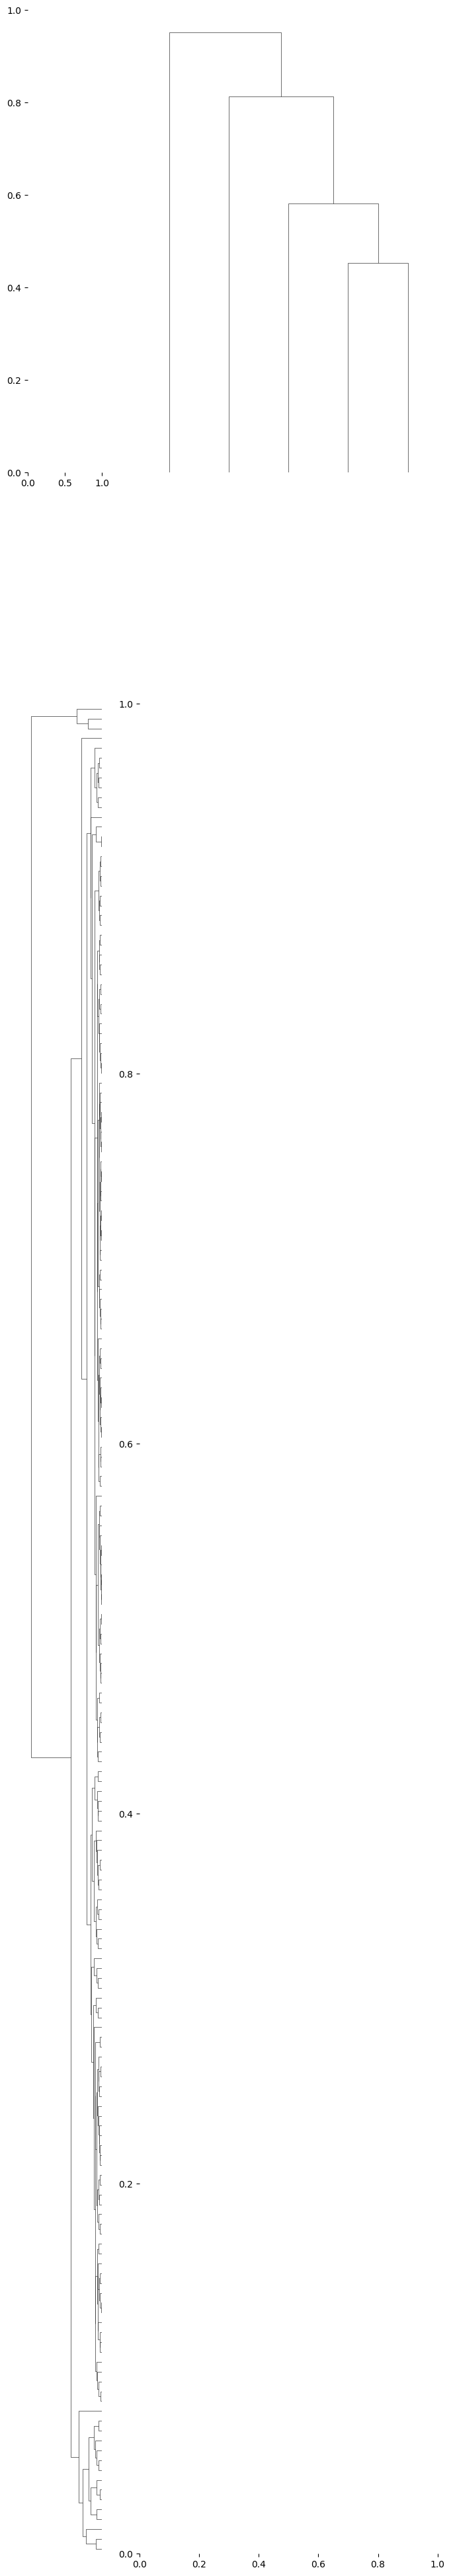

In [209]:
result = tf_activity_analysis(anndataobject= "LR2TF_test_run/anndata_object.h5ad", arguments_list= {"out_path" : "script_test", "celltype" : "new_annotation", "condition" : "protocol", "organism" : None, "comparison_list" : None, "logfc" : "0.5", "pval" : None, "reg" : "filterd_regulon.csv", "tf_activities" : "decoupler_results.csv", "plot" : True})


In [ ]:
def csv_comparison (result_1, result_2, outpath, suffixes_df=("_py", "_r")):
    result1 = pd.read_csv(result_1)
    result2 = pd.read_csv(result_2)


    result1 = result1[result1["pvals_adj"] < 0.05]
    if "p_val_adj" in result2.columns:
        result2 = result2[result2["p_val_adj"] < 0.05]
    else:
        result2 = result2[result2["pvals_adj"] < 0.05]

    result1 = result1.rename(columns={"names": "gene", "group": "cluster"})
    result2 = result2.rename(columns={"names": "gene", "group": "cluster"})


    df_output_1 = pd.DataFrame()

    for i in range(len(result1)):
        a = result1["gene"].iloc[i]
        for j in range(len(result2)):
            b = result2["gene"].iloc[j]
            if a == b:
                df_output_1[i] = result1.iloc[i]
            

    df_output_1 = df_output_1.T

    df_output_2 = pd.DataFrame()
    for i in range(len(result2)):
        a = result2["gene"].iloc[i]
        for j in range(len(result1)):
            b = result1["gene"].iloc[j]
            if a == b:
                df_output_2[i] = result2.iloc[i]


    df_output_2 = df_output_2.T


    df_output = pd.merge(df_output_1, df_output_2, on="gene", suffixes=suffixes_df)

    df_output_3 = pd.DataFrame()
    for i in range(len(result1)):
        a = result1["gene"].iloc[i]
        b = list(result2["gene"])
        if a not in b:
            df_output_3[i] = result1.iloc[i]
            
    df_output_3 = df_output_3.T
    df_output.rename(columns={"Unnamed: 0": "gene_r"}, inplace=True)
    df_output_3.rename(columns={"cluster": "cluster" + suffixes_df[0]}, inplace=True)
    if suffixes_df[0] == "_py_wilcox":
        df_output_3.rename(columns={"scores": "scores" + suffixes_df[0], "logfoldchanges": "logfoldchanges" + suffixes_df[0], "pvals": "pvals" + suffixes_df[0], "pvals_adj": "pvals_adj" + suffixes_df[0]}, inplace=True)
        df_output_4 = pd.DataFrame()
        for i in range(len(result2)):
            a = result2["gene"].iloc[i]
            b = list(result1["gene"])
            if a not in b:
                df_output_4[i] = result2.iloc[i]
        df_output_4 = df_output_4.T
        df_output_4.rename(columns={"cluster": "cluster" + suffixes_df[1], "scores": "scores" + suffixes_df[1], "logfoldchanges": "logfoldchanges" + suffixes_df[1], "pvals": "pvals" + suffixes_df[1], "pvals_adj": "pvals_adj" + suffixes_df[1]}, inplace=True)
        df_output_3 = pd.concat([df_output_3, df_output_4])
        

    df_output = pd.concat([df_output, df_output_3])

    df_output.to_csv(outpath, index=0)
    print(df_output_3.columns)



In [ ]:
#WINDOWS VERSION

#CONTROL
#comparison python wilcoxon and r wilcoxon control
csv_comparison("script_test\\TF_results\\control\\control_specific_markers_wilcoxon_test.csv", "LR2TF_test_run\\results\\TF_results\\control\\all_specificmarker__control.csv",
                "tf_comparison_r_py\\py_wilcoxon_r_same_genes_control_filtered.csv", suffixes_df=("_py", "_r"))

#comparison python t test and r wilcoxon control
csv_comparison("script_test\\TF_results\\control\\control_specific_markers_t_test_overestim_test.csv", "LR2TF_test_run\\results\\TF_results\\control\\all_specificmarker__control.csv",
                "tf_comparison_r_py\\py_t_test_r_same_genes_control_filtered.csv", suffixes_df=("_py", "_r"))

# py wilcox vs py t test control

csv_comparison("script_test\\TF_results\\control\\control_specific_markers_wilcoxon_test.csv", "script_test\\TF_results\\control\\control_specific_markers_t_test_overestim_test.csv",
                "tf_comparison_r_py\\py_wilcox_py_t_test_same_genes_control_filtered.csv", suffixes_df=("_py_wilcox", "_py_t_test"))
################################################################################################################################################################################################
#PMF MF2
#python wilcox vs r wilcox PMF MF2
csv_comparison("script_test\\TF_results\\PMF_MF2\\PMF_MF2_specific_markers_wilcoxon_test.csv", "LR2TF_test_run\\results\\TF_results\\PMF_MF2\\all_specificmarker__PMF_MF2.csv",
                "tf_comparison_r_py\\py_wilcoxon_r_same_genes_PMF_MF2_filtered.csv", suffixes_df=("_py", "_r"))

#comparison python t test and r wilcoxon PMF MF2
csv_comparison("script_test\\TF_results\\PMF_MF2\\PMF_MF2_specific_markers_t_test_overestim_test.csv", "LR2TF_test_run\\results\\TF_results\\PMF_MF2\\all_specificmarker__PMF_MF2.csv",
                "tf_comparison_r_py\\py_t_test_r_same_genes_PMF_MF2_filtered.csv", suffixes_df=("_py", "_r"))

csv_comparison("script_test\\TF_results\\PMF_MF2\\PMF_MF2_specific_markers_wilcoxon_test.csv", "script_test\\TF_results\\PMF_MF2\\PMF_MF2_specific_markers_t_test_overestim_test.csv",
                "tf_comparison_r_py\\py_wilcox_py_t_test_same_genes_PMF_MF2_filtered.csv", suffixes_df=("_py_wilcox", "_py_t_test"))

In [ ]:
#LINUX VERSION

#CONTROL
#comparison python wilcoxon and r wilcoxon control
csv_comparison("script_test/TF_results/control/control_specific_markers_wilcoxon_test.csv", "LR2TF_test_run/results/TF_results/control/all_specificmarker__control.csv",
                "tf_comparison_r_py//py_wilcoxon_r_same_genes_control_filtered.csv", suffixes_df=("_py", "_r"))

#comparison python t test and r wilcoxon control
csv_comparison("script_test/TF_results/control/control_specific_markers_t_test_overestim_test.csv", "LR2TF_test_run/results/TF_results/control/all_specificmarker__control.csv",
                "tf_comparison_r_py/py_t_test_r_same_genes_control_filtered.csv", suffixes_df=("_py", "_r"))

# py wilcox vs py t test control

csv_comparison("script_test/TF_results/control/control_specific_markers_wilcoxon_test.csv", "script_test/TF_results/control/control_specific_markers_t_test_overestim_test.csv",
                "tf_comparison_r_py/py_wilcox_py_t_test_same_genes_control_filtered.csv", suffixes_df=("_py_wilcox", "_py_t_test"))
################################################################################################################################################################################################
#PMF MF2
#python wilcox vs r wilcox PMF MF2
csv_comparison("script_test/TF_results/PMF_MF2/PMF_MF2_specific_markers_wilcoxon_test.csv", "LR2TF_test_run/results/TF_results/PMF_MF2/all_specificmarker__PMF_MF2.csv",
                "tf_comparison_r_py/py_wilcoxon_r_same_genes_PMF_MF2_filtered.csv", suffixes_df=("_py", "_r"))

#comparison python t test and r wilcoxon PMF MF2
csv_comparison("script_test/TF_results/PMF_MF2/PMF_MF2_specific_markers_t_test_overestim_test.csv", "LR2TF_test_run/results/TF_results/PMF_MF2/all_specificmarker__PMF_MF2.csv",
                "tf_comparison_r_py/py_t_test_r_same_genes_PMF_MF2_filtered.csv", suffixes_df=("_py", "_r"))

csv_comparison("script_test/TF_results/PMF_MF2/PMF_MF2_specific_markers_wilcoxon_test.csv", "script_test/TF_results/PMF_MF2/PMF_MF2_specific_markers_t_test_overestim_test.csv",
                "tf_comparison_r_py/py_wilcox_py_t_test_same_genes_PMF_MF2_filtered.csv", suffixes_df=("_py_wilcox", "_py_t_test"))